In [2]:
import pandas as pd 
import numpy as np
import ast 
import matplotlib.pyplot as plt 
import glob
import re 

BUCKET = 'd3-ai-orion'
S3_URL = 'https://{}.s3.amazonaws.com/{}'

BENCHMARK_DATA = pd.read_csv(S3_URL.format(
    BUCKET, 'datasets.csv'), index_col=0, header=None).applymap(ast.literal_eval).to_dict()[1]

# Load datasets 

## mSSA


In [62]:
df_mssa_scores = pd.read_pickle("mssa_scores.pkl").query("mssa_rank == 2")
df_mssa_summary = pd.read_pickle("mssa_summaries.pkl").query("mssa_rank == 2")

In [63]:
df_optmssa_scores = pd.read_pickle("mssa_scores.pkl").sort_values("f1", ascending=False).drop_duplicates("signal", keep="first")
df_optmssa_summary = pd.read_pickle("mssa_summaries.pkl").sort_values("f1", ascending=False).drop_duplicates("dataset", keep="first")

df_optmssa_scores['pipeline'] = "mssa_opt"
df_optmssa_summary['pipeline'] = "mssa_opt"

In [ ]:
# df_mssa_summary.groupby("mssa_rank")['f1'].agg([np.mean, np.std])

In [ ]:
pd.read_pickle("mssa_summaries.pkl").query("dataset=='YAHOOA3'").sort_values("f1", ascending=False)

## Prophet 

In [4]:
df_prophet_scores = pd.read_csv("prophet_deepar_results/final/scores_prophet.csv")
df_prophet_summary = pd.read_csv("prophet_deepar_results/final/summary_prophet.csv")

## DeepAR 

In [5]:
df_deepar_scores = pd.read_csv("prophet_deepar_results/final/scores_deepar.csv")
df_deepar_summary = pd.read_csv("prophet_deepar_results/final/summary_deepar.csv")

## Orbit 

In [6]:
df_orbit_scores = pd.concat([pd.read_pickle("yahoo_results/orbit_scores_flat.pkl"),
                             pd.read_pickle("numenta_results/orbit_scores_flat.pkl"),
                             pd.read_pickle("nasa_results/orbit_scores_split_flat.pkl")], ignore_index = True)


df_orbit_summary = pd.concat([pd.read_pickle("yahoo_results/orbit_summaries_flat.pkl"),
                             pd.read_pickle("numenta_results/orbit_summaries_flat.pkl"),
                             pd.read_pickle("nasa_results/orbit_summaries_split_flat.pkl")], ignore_index = True)

# Sanity checks 

In [7]:
#number of summaries 
for df in [df_optmssa_summary, df_mssa_summary, df_prophet_summary, df_deepar_summary, df_orbit_summary]:
    print(len(df))


print("\n\n")

#number of errors in scores 
for df in [df_optmssa_scores, df_mssa_scores, df_prophet_scores, df_deepar_scores, df_orbit_scores]:
    print(len(df))
    print(df.status.value_counts())

    

11
11
11
11
11



492
0    492
Name: status, dtype: int64
492
0    492
Name: status, dtype: int64
492
0    492
Name: status, dtype: int64
492
0    492
Name: status, dtype: int64
492
0    472
1     20
Name: status, dtype: int64


# Analyses 

## Scores and durations

In [8]:
pd.concat([df_optmssa_summary, df_mssa_summary, df_prophet_summary, df_deepar_summary, df_orbit_summary], ignore_index=True).loc[:,:"f1"].pivot(index="pipeline", columns="dataset", values="f1").round(2)

dataset,MSL,SMAP,YAHOOA1,YAHOOA2,YAHOOA3,YAHOOA4,artificialWithAnomaly,realAWSCloudwatch,realAdExchange,realTraffic,realTweets
pipeline,,,,,,,,,,,
deepar,0.39,0.48,0.65,0.97,0.67,0.52,0.80,0.44,0.48,0.57,0.55
mssa,0.39,0.23,0.69,0.89,0.96,0.69,0.26,0.33,0.53,0.52,0.15
mssa_opt,0.48,0.43,0.75,0.93,1.00,0.90,0.36,0.33,0.59,0.52,0.15
orbit,0.34,0.28,0.81,0.98,1.00,0.87,0.10,0.32,0.53,0.63,0.15
prophet,0.39,0.41,0.54,0.82,0.33,0.17,0.60,0.60,0.47,0.53,0.53


In [9]:
pd.DataFrame(pd.concat([df_optmssa_scores, df_mssa_scores, df_prophet_scores, df_deepar_scores, df_orbit_scores], 
                       ignore_index=True).groupby(['pipeline','dataset'])['elapsed'].agg(np.median).round(2)).reset_index().pivot(index="pipeline", columns="dataset", values="elapsed")

dataset,MSL,SMAP,YAHOOA1,YAHOOA2,YAHOOA3,YAHOOA4,artificialWithAnomaly,realAWSCloudwatch,realAdExchange,realTraffic,realTweets
pipeline,,,,,,,,,,,
deepar,267.20,469.50,209.03,216.40,250.86,183.92,271.25,325.97,968.17,399.45,517.01
mssa,0.13,0.29,0.12,0.12,0.12,0.12,0.24,0.21,0.11,0.13,0.61
mssa_opt,0.13,0.30,0.12,0.12,0.12,0.12,0.19,0.20,0.12,0.13,0.62
orbit,20.59,25.89,10.11,9.08,10.72,10.70,19.37,30.63,9.79,13.11,232.25
prophet,222.91,412.51,6.96,11.65,16.73,16.12,227.93,176.53,1146.15,213.28,788.63


## mssa scores with changing rank 

Text(0, 0.5, 'F1 Score')

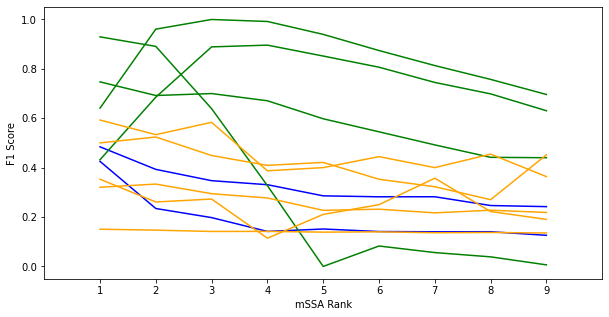

In [10]:
df_allmssa_summaries = pd.read_pickle("mssa_summaries.pkl")

plt.figure(figsize=(10,5))
for dataset in BENCHMARK_DATA.keys():
#     plt.figure()
#     plt.scatter([-1],df_allmssa_summaries.query("dataset == @dataset").f1.values[0])
#     plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:])

    if dataset in {"SMAP", "MSL"}:
        plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:], c="blue", label="NASA")
    elif "YAHOO" in dataset:
        plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:], c="green", label="Yahoo")
    else:
        plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:], c="orange", label="Numenta")
    
#     plt.title(dataset)

# plt.legend()
plt.xlim(0,10)
plt.xticks(list(range(1,10)))
plt.ylim(-0.05,1.05)
plt.xlabel("mSSA Rank")
plt.ylabel("F1 Score")

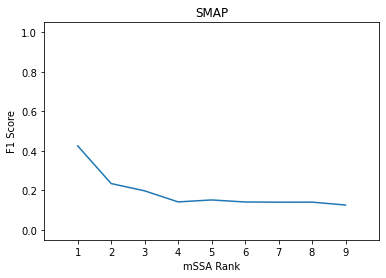

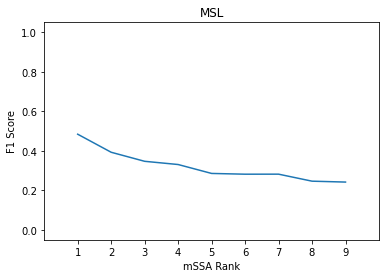

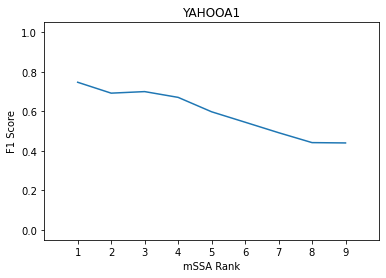

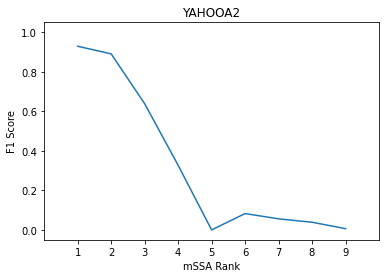

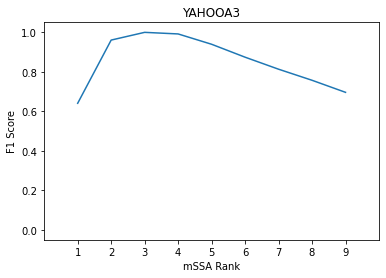

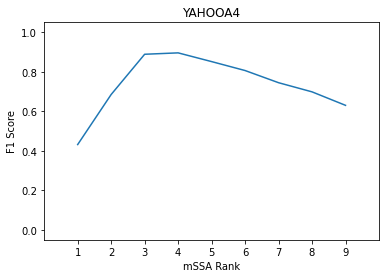

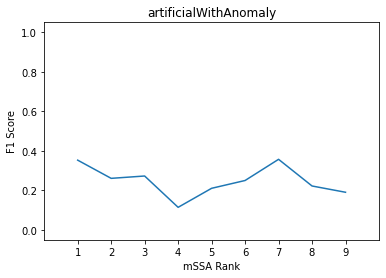

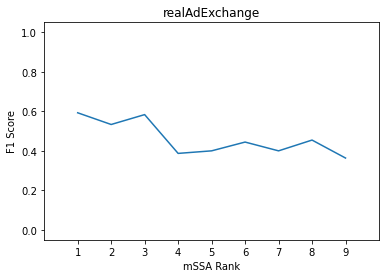

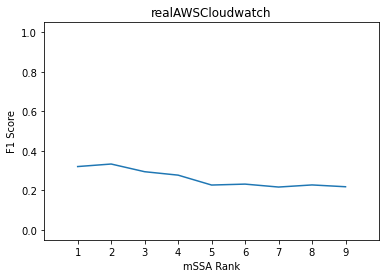

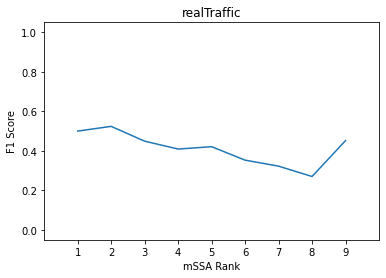

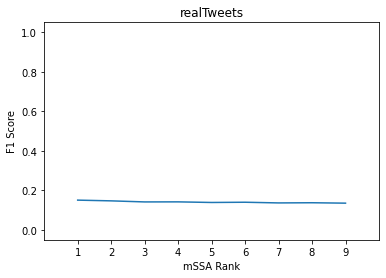

In [11]:
for dataset in BENCHMARK_DATA.keys():
    plt.figure()
#     plt.scatter([-1],df_allmssa_summaries.query("dataset == @dataset").f1.values[0])
    plt.plot(list(range(1,10)),df_allmssa_summaries.query("dataset == @dataset").f1.values[1:])
    plt.title(dataset)
    plt.xlabel("mSSA Rank")
    plt.ylabel("F1 Score")
    plt.xlim(0,10)
    plt.xticks(list(range(1,10)))
    plt.ylim(-0.05,1.05)

## Dataset spectral analysis 

In [64]:
#for nasa, calculating spectra on train data  
filepaths = [x for x in glob.glob("./Orion/orion/data/**", recursive=True) if x.endswith(".csv") and "_all" not in x and "-test" not in x]

In [65]:
df_optmssa_spectra = df_optmssa_scores.copy()
spectra_dict = {}



for filepath in filepaths: 
    try:
        signal_name = filepath.split("/")[-1][:-4]
        signal_name = re.sub("-train", "", signal_name)

        temp_df = pd.read_csv(filepath)
        m_dim = int(np.sqrt(len(temp_df)))
        n_dim = len(temp_df)//m_dim
        m = np.reshape(temp_df.value.values[:m_dim*n_dim], (m_dim,n_dim))
        m = m - m.mean()

        u,s,_ = np.linalg.svd(m)
        # s = s/s[0]
        S = np.cumsum(s**2)
        S = S/S[-1]

#         df_optmssa_spectra.loc[df_optmssa_spectra['signal'] == signal_name, "energy"] = str(S)
        spectra_dict[signal_name] = S
    
    except:
        print(filepath)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


./Orion/orion/data/anomalies.csv


In [66]:
df_optmssa_spectra['energy'] = df_optmssa_spectra['signal'].map(spectra_dict)

In [67]:
#get energy at optimimum level
df_optmssa_spectra.loc[(~df_optmssa_spectra['energy'].isnull()) & (~df_optmssa_spectra['mssa_rank'].isnull()), "optimal_energy_level"] = df_optmssa_spectra[~df_optmssa_spectra['energy'].isnull()][~df_optmssa_spectra['mssa_rank'].isnull()].apply(lambda x: x.energy[int(x.mssa_rank)], axis=1)

(-0.06517660043816778, 1.065176600371501)

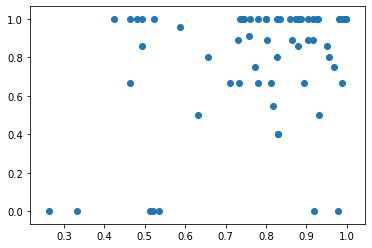

In [68]:
sv_index = 2
dataset = "YAHOOA1"
energy_levels = [x[sv_index] for x in df_optmssa_spectra.query("dataset == @dataset")['energy']]
# opt_energy_levels = 
f1_scores = df_optmssa_spectra.query("dataset == @dataset").f1.values

plt.scatter(energy_levels, f1_scores)
plt.ylim()

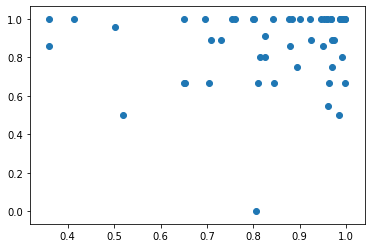

In [69]:
plt.scatter(df_optmssa_spectra.query("dataset == 'YAHOOA1'")['optimal_energy_level'], df_optmssa_spectra.query("dataset == 'YAHOOA1'")['f1'])

(-0.06517660043650111, 1.065176600336501)

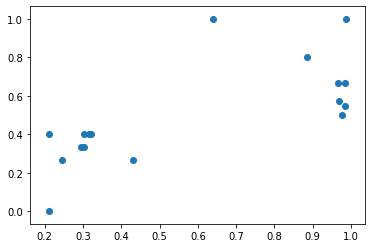

In [70]:
sv_index = 1
dataset = "realAWSCloudwatch"
energy_levels = [x[sv_index] for x in df_optmssa_spectra.query("dataset == @dataset")['energy']]
# opt_energy_levels = 
f1_scores = df_optmssa_spectra.query("dataset == @dataset").f1.values

plt.scatter(energy_levels, f1_scores)
plt.ylim()

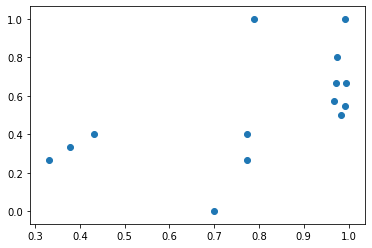

In [71]:
plt.scatter(df_optmssa_spectra.query("dataset == 'realAWSCloudwatch'")['optimal_energy_level'], df_optmssa_spectra.query("dataset == 'realAWSCloudwatch'")['f1'])

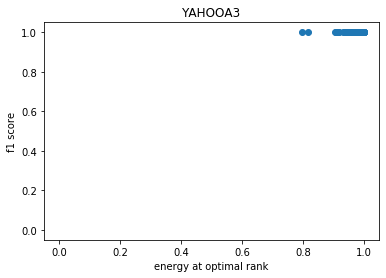

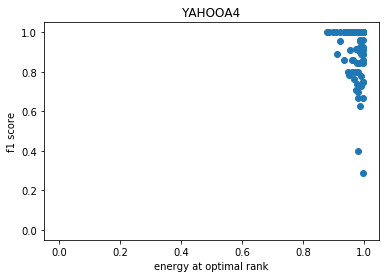

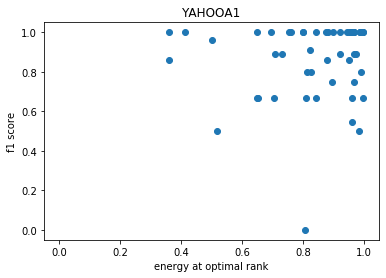

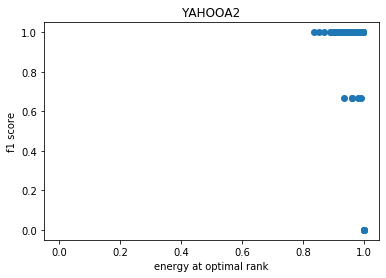

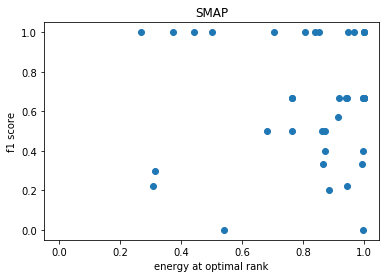

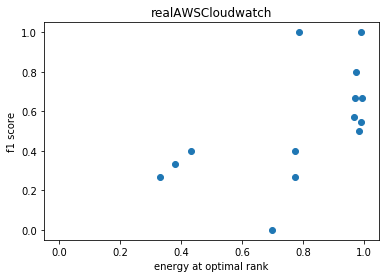

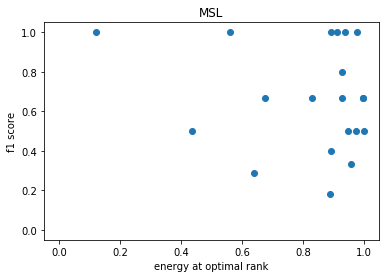

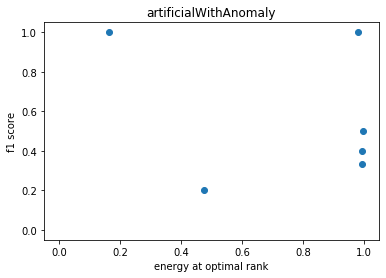

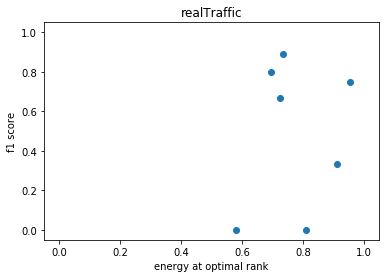

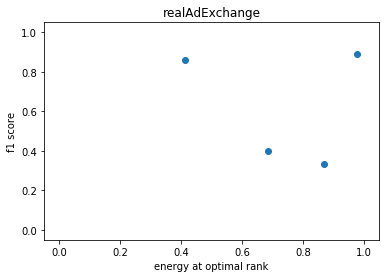

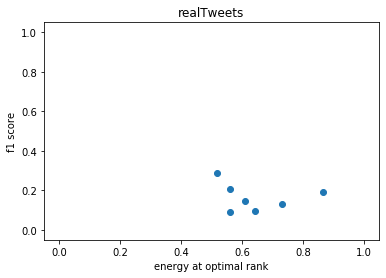

In [72]:
#Caveat: we don't have rank for when "None" is best 

for dataset in df_optmssa_spectra.dataset.unique():
    try:
        plt.figure()
        plt.scatter(df_optmssa_spectra.query("dataset == @dataset")['optimal_energy_level'], df_optmssa_spectra.query("dataset == @dataset")['f1'])
        plt.title(dataset)
        plt.xlabel("energy at optimal rank")
        plt.ylabel("f1 score")
        plt.ylim(-0.05,1.05)
        plt.xlim(-0.05,1.05)
    except:
        print(dataset)

## Color spectra by accuracy 

In [73]:
import matplotlib
import matplotlib.cm as cm

In [74]:
norm = matplotlib.colors.Normalize(vmin=df_optmssa_spectra.f1.min(), vmax=df_optmssa_spectra.f1.max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

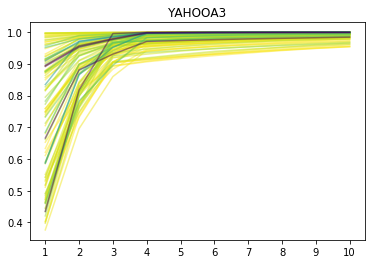

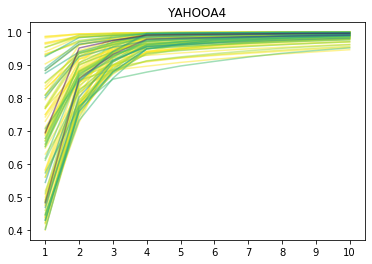

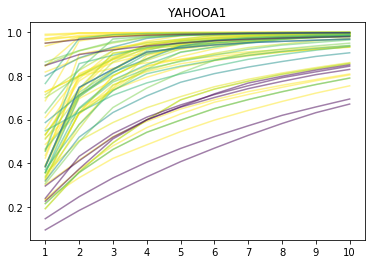

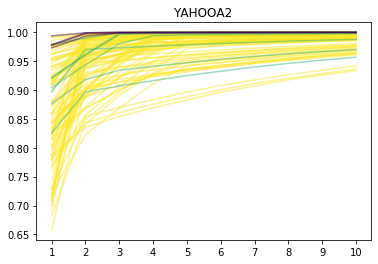

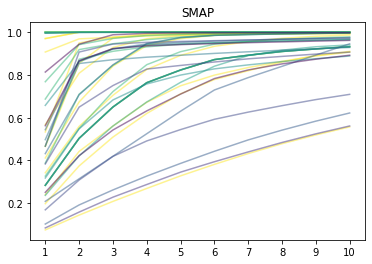

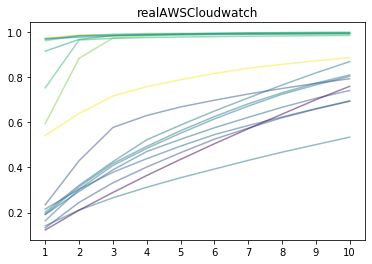

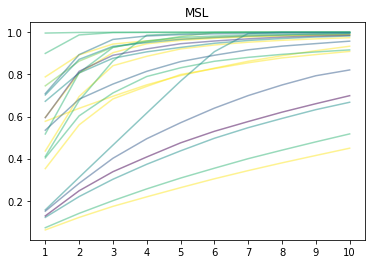

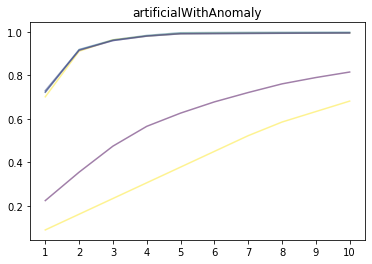

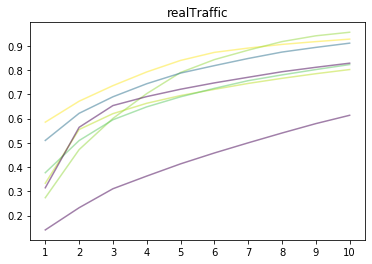

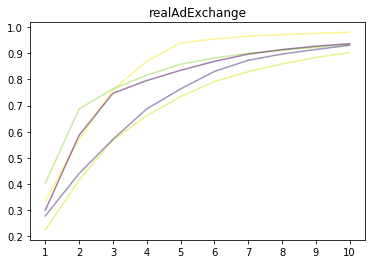

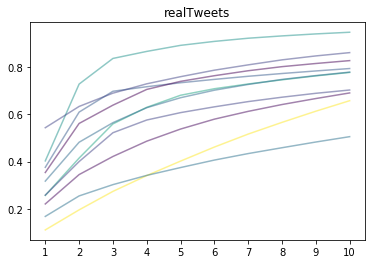

In [75]:
for dataset in df_optmssa_spectra.dataset.unique():
    plt.figure()
    norm = matplotlib.colors.Normalize(vmin=df_optmssa_spectra.query("dataset == @dataset").f1.min(), vmax=df_optmssa_spectra.query("dataset == @dataset").f1.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    
    for row in df_optmssa_spectra.query("dataset == @dataset").itertuples():
        plt.plot(range(1,11), row.energy[:10], c=mapper.to_rgba(row.f1), alpha=0.5)
#     for spectrum in df_optmssa_spectra.query("dataset == @dataset").energy.values:
#             plt.plot(range(1,11), spectrum[:10], color="blue", alpha=0.2)
    
    
    plt.xticks(range(1,11))
    plt.title(dataset)

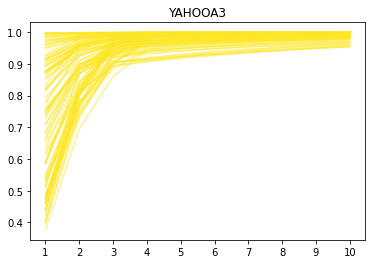

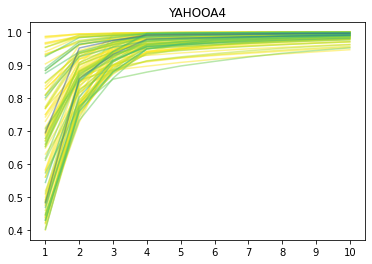

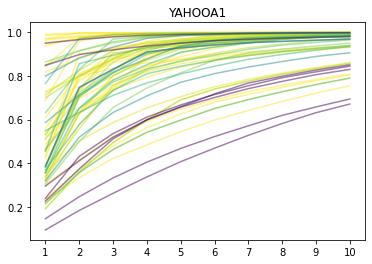

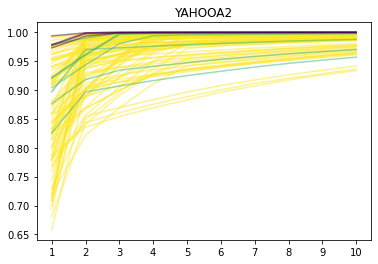

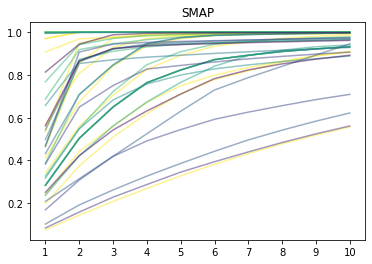

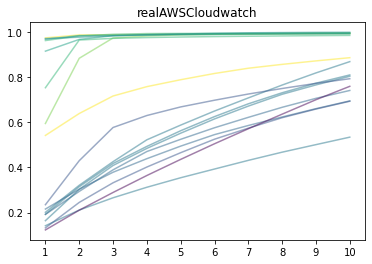

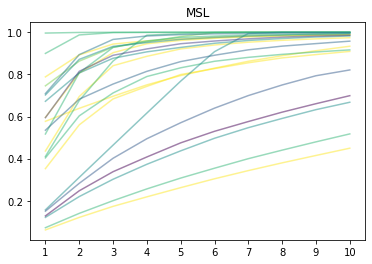

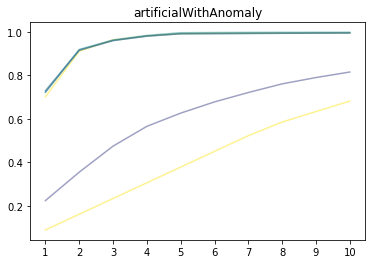

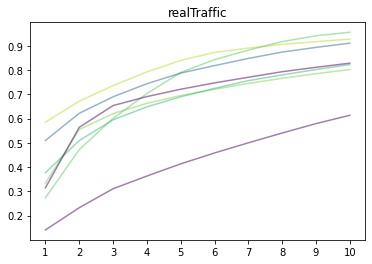

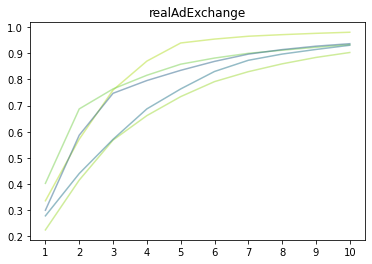

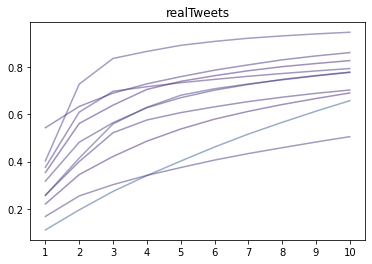

In [37]:
for dataset in df_optmssa_spectra.dataset.unique():
    plt.figure()
    
    
    for row in df_optmssa_spectra.query("dataset == @dataset").itertuples():
        plt.plot(range(1,11), row.energy[:10], c=mapper.to_rgba(row.f1), alpha=0.5)
#     for spectrum in df_optmssa_spectra.query("dataset == @dataset").energy.values:
#             plt.plot(range(1,11), spectrum[:10], color="blue", alpha=0.2)
    
    
    plt.xticks(range(1,11))
    plt.title(dataset)

In [ ]:
for dataset in df_optmssa_spectra.dataset.unique():    
    
    for row in df_optmssa_spectra.query("dataset == @dataset").itertuples():
        plt.plot(range(1,11), row.energy[:10], c=mapper.to_rgba(row.f1), alpha=0.5)
#     for spectrum in df_optmssa_spectra.query("dataset == @dataset").energy.values:
#             plt.plot(range(1,11), spectrum[:10], color="blue", alpha=0.2)
    
    
    plt.xticks(range(1,11))
    plt.title(dataset)

In [77]:
df_optmssa_spectra['energy_top10'] = [x[:10] for x in df_optmssa_spectra['energy']]

In [78]:
spectra_means = df_optmssa_spectra.dropna(subset=["optimal_energy_level"]).groupby("dataset")['energy_top10'].apply(np.mean)

Text(0, 0.5, 'Cumulative "energy" of singular values')

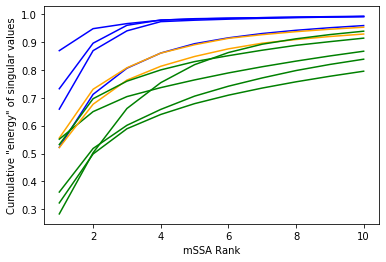

In [80]:
for dataset in df_optmssa_spectra.dataset.unique(): 
    if dataset in {"SMAP", "MSL"}:
        plt.plot(range(1,11), spectra_means[dataset], c="orange", label="NASA")
    elif "YAHOO" in dataset:
        plt.plot(range(1,11), spectra_means[dataset], c="blue", label="YAHOO")
    else:
        plt.plot(range(1,11), spectra_means[dataset], c="green", label="NAB")
    
plt.xlabel("mSSA Rank")
plt.ylabel('Cumulative "energy" of singular values')

In [62]:
list(zip(spectra_means.index, [x[-1] for x in spectra_means]))

[('MSL', 0.927945608012387),
 ('SMAP', 0.9523452205133862),
 ('YAHOOA1', 0.9582156220945053),
 ('YAHOOA2', 0.9904204048919),
 ('YAHOOA3', 0.9916320696157921),
 ('YAHOOA4', 0.9903156291472338),
 ('artificialWithAnomaly', 0.9131743029079492),
 ('realAWSCloudwatch', 0.8663907148558823),
 ('realAdExchange', 0.9381172910763684),
 ('realTraffic', 0.8378340507612164),
 ('realTweets', 0.7948361362259005)]

# Synthetic Experiments 

In [12]:
df_synth_scores = pd.read_pickle("mssa_synthetic_scores.pkl")
df_synth_summaries = pd.read_pickle("mssa_synthetic_summaries.pkl")
df_synth_h_summaries = pd.read_pickle("mssa_synthetic_summaries_h.pkl")

df_synth_h_summaries['num_harmonics'] = [int(x[1:]) for x in df_synth_h_summaries.harmonics]

In [8]:
df_synth_summaries

,dataset,pipeline,category,fp,fn,tp,f1,rank
0,custom,mssa,highrank,44,427,10,0.040733,None
1,custom,mssa,lowrank,44,214,218,0.628242,None
2,custom,mssa,highrank,44,431,6,0.024641,1
3,custom,mssa,lowrank,46,385,47,0.179048,1
4,custom,mssa,highrank,64,432,5,0.019763,2
...,...,...,...,...,...,...,...,...
91,custom,mssa,lowrank,364,365,67,0.155272,45
92,custom,mssa,highrank,367,363,74,0.168565,46
93,custom,mssa,lowrank,424,342,90,0.190275,46
94,custom,mssa,highrank,441,334,103,0.209990,47


In [21]:
df_synth_summaries.query("category == 'highrank'")['rank']

0     None
2        1
4        2
6        3
8        4
10       5
12       6
14       7
16       8
18       9
20      10
22      11
24      12
26      13
28      14
30      15
32      16
34      17
36      18
38      19
40      20
42      21
44      22
46      23
48      24
50      25
52      26
54      27
56      28
58      29
60      30
62      31
64      32
66      33
68      34
70      35
72      36
74      37
76      38
78      39
80      40
82      41
84      42
86      43
88      44
90      45
92      46
94      47
Name: rank, dtype: object

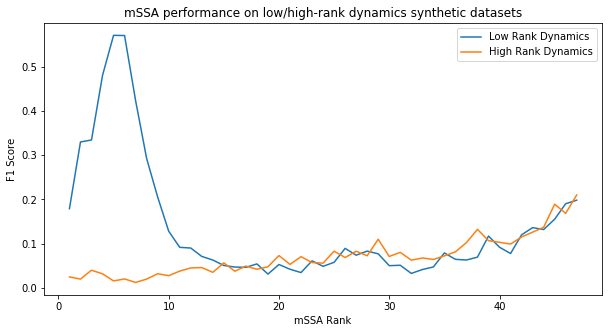

In [27]:
plt.figure(figsize=(10,5))

plt.plot(df_synth_summaries.query("category == 'lowrank'")['rank'], df_synth_summaries.query("category == 'lowrank'").f1, label="Low Rank Dynamics")
plt.plot(df_synth_summaries.query("category == 'highrank'")['rank'], df_synth_summaries.query("category == 'highrank'").f1, label="High Rank Dynamics")
plt.xlabel("mSSA Rank")
plt.ylabel("F1 Score")
plt.title("mSSA performance on low/high-rank dynamics synthetic datasets")
plt.legend()

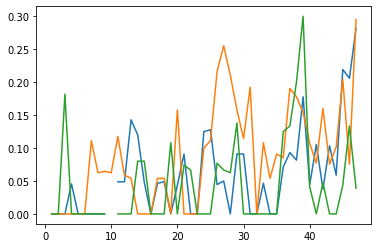

In [37]:
plot_cat = "highrank"
plt.plot(df_synth_h_summaries.query("num_harmonics == 1 and category == @plot_cat")['rank'], df_synth_h_summaries.query("num_harmonics == 1 and category == @plot_cat")['f1'])
plt.plot(df_synth_h_summaries.query("num_harmonics == 8 and category == @plot_cat")['rank'], df_synth_h_summaries.query("num_harmonics == 8 and category == @plot_cat")['f1'])
plt.plot(df_synth_h_summaries.query("num_harmonics == 14 and category == @plot_cat")['rank'], df_synth_h_summaries.query("num_harmonics == 14 and category == @plot_cat")['f1'])


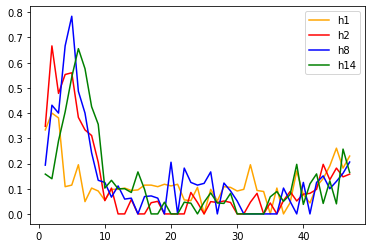

In [44]:
plot_cat = "lowrank"
plt.plot(df_synth_h_summaries.query("num_harmonics == 1 and category == @plot_cat")['rank'], df_synth_h_summaries.query("num_harmonics == 1 and category == @plot_cat")['f1'], c="orange", label="h1")
plt.plot(df_synth_h_summaries.query("num_harmonics == 2 and category == @plot_cat")['rank'], df_synth_h_summaries.query("num_harmonics == 2 and category == @plot_cat")['f1'], c="red", label="h2")
plt.plot(df_synth_h_summaries.query("num_harmonics == 8 and category == @plot_cat")['rank'], df_synth_h_summaries.query("num_harmonics == 8 and category == @plot_cat")['f1'], c="blue", label="h8")
plt.plot(df_synth_h_summaries.query("num_harmonics == 14 and category == @plot_cat")['rank'], df_synth_h_summaries.query("num_harmonics == 14 and category == @plot_cat")['f1'], c="green", label="h14")

plt.legend()

(1, 10)

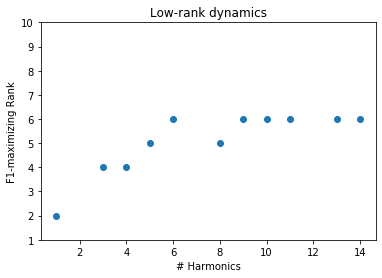

In [61]:
plt.scatter(df_synth_h_summaries.query("category=='lowrank'").sort_values("f1", ascending=False).drop_duplicates("num_harmonics", keep="first")['num_harmonics'].values,
         df_synth_h_summaries.query("category=='lowrank'").sort_values("f1", ascending=False).drop_duplicates("num_harmonics", keep="first")['rank'].values)

plt.xlabel("# Harmonics")
plt.ylabel("F1-maximizing Rank")
plt.title("Low-rank dynamics")
plt.ylim(1,10)


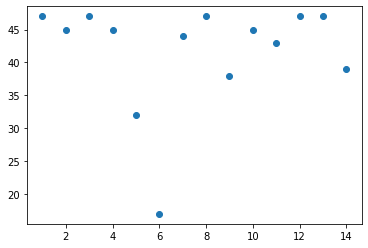

In [59]:
plt.scatter(df_synth_h_summaries.query("category=='highrank'").sort_values("f1", ascending=False).drop_duplicates("num_harmonics", keep="first")['num_harmonics'],
         df_synth_h_summaries.query("category=='highrank'").sort_values("f1", ascending=False).drop_duplicates("num_harmonics", keep="first")['rank'])